In [ ]:
!pip install CoolProp
!pip install pyswarms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 1.8 MB/s eta 0:00:00


In [ ]:
import CoolProp.CoolProp as CP
import numpy as np
import pyswarms as ps

# Valores fixados
refri1 = 'R123'  # Ciclo superior
refri2 = 'R600a'  # Ciclo inferior
carga_termica = 2000  # Carga térmica em watts
delta_T = 5  # Diferença de temperatura no trocador
T_cond = 50 + 273.15  # Temperatura de condensação do ciclo 1 (50°C)
efi = 0.7
superaquecimento = 5  # Superaquecimento fixo em 5 °C

# Função para calcular o COP e variáveis adicionais
def calcular_COP_e_UA(P_3, P_sep):
    # Estado 1
    Temperatura_1 = -25 + 273.15
    h_1 = CP.PropsSI('H', 'T', Temperatura_1, 'Q', 1, refri2)
    P_1 = CP.PropsSI('P', 'T', Temperatura_1, 'Q', 1, refri2)

    # Estado 2
    P_2 = P_1
    Temperatura_2 = Temperatura_1 + superaquecimento
    h_2 = CP.PropsSI('H', 'T', Temperatura_2, 'P', P_2, refri2)
    s_2 = CP.PropsSI('S', 'T', Temperatura_2, 'P', P_2, refri2)

    # Estado 3
    s_3s = s_2
    h_3s = CP.PropsSI('H', 'S', s_3s, 'P', P_3, refri2)
    h_3 = ((h_3s - h_2) / efi) + h_2
    Temperatura_3 = CP.PropsSI('T', 'H', h_3, 'P', P_3, refri2)
    s_3 = CP.PropsSI('S', 'H', h_3, 'P', P_3, refri2)

    # Estado 4
    h_4 = CP.PropsSI('H', 'P', P_3, 'Q', 0, refri2)
    Temperatura_4 = CP.PropsSI('T', 'P', P_3, 'Q', 0, refri2)
    s_4 = CP.PropsSI('S', 'P', P_3, 'Q', 0, refri2)

    # Estado 5
    h_5 = h_1 + h_4 - h_2

    # Estado 6
    h_6 = h_5

    # Estado 7
    Temperatura_7 = Temperatura_4 - delta_T
    h_7 = CP.PropsSI('H', 'T', Temperatura_7, 'Q', 1, refri1)
    s_7 = CP.PropsSI('S', 'T', Temperatura_7, 'Q', 1, refri1)
    P_7 = CP.PropsSI('P', 'T', Temperatura_7, 'Q', 1, refri1)

    # Estado 8
    P_8 = P_sep
    s_8s = s_7
    h_8s = CP.PropsSI('H', 'P', P_8, 'S', s_8s, refri1)
    h_8 = ((h_8s - h_7) / efi) + h_7

    # Estado 9
    P_9 = P_sep
    h_9 = CP.PropsSI('H', 'P', P_9, 'Q', 0, refri1)

    # Estado 10
    h_10 = h_9
    Temperatura_10 = CP.PropsSI('T', 'P', P_7, 'H', h_10, refri1)
    s_10 = CP.PropsSI('S', 'P', P_7, 'H', h_10, refri1)

    # Estado 11
    P_11 = P_sep
    h_11 = CP.PropsSI('H', 'P', P_11, 'Q', 1, refri1)
    s_11 = CP.PropsSI('S', 'P', P_11, 'Q', 1, refri1)

    # Estado 13
    P_13 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
    h_13 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)

    # Estado 12
    P_12 = P_13
    h_12s = CP.PropsSI('H', 'P', P_12, 'S', s_11, refri1)
    h_12 = ((h_12s - h_11) / efi) + h_11

    # Estado 14
    h_14 = h_13

    # Cálculo das vazões mássicas
    m1 = carga_termica / (h_1 - h_6)
    m2 = m1 * ((h_3 - h_4) / (h_7 - h_10))
    m3 = m2 * ((h_8 - h_9) / (h_11 - h_14))

    # Trabalhos e COP
    w1 = m1 * (h_3 - h_2)
    w2 = m2 * (h_8 - h_7)
    w3 = m3 * (h_12 - h_11)
    COP = carga_termica / (w1 + w2 + w3)

    # Cálculo do UA
    delta_T_m = (((Temperatura_3 - Temperatura_10) - (Temperatura_4 - Temperatura_7)) / np.log((Temperatura_3 - Temperatura_10) / (Temperatura_4 - Temperatura_7)))
    Q = m2 * (h_7 - h_10)
    UA = Q / delta_T_m

    return COP, UA

# Função objetivo para o PSO
def funcao_objetivo(x):
    P_3, P_sep = x[:, 0], x[:, 1]
    COP_valores = np.array([-calcular_COP_e_UA(P_3[i], P_sep[i])[0] for i in range(len(P_3))])
    return COP_valores

# Limites de busca
P3_min, P3_max = 58427 , 200000  # Limite para P3
Psep_min, Psep_max = 6747, 212462  # Limite para Psep

# Configuração do PSO
opcoes = {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
limites = (np.array([P3_min, Psep_min]), np.array([P3_max, Psep_max]))
optimizer = ps.single.GlobalBestPSO(n_particles=15, dimensions=2, options=opcoes, bounds=limites)

# Execução do PSO
melhor_custo, melhor_posicao = optimizer.optimize(funcao_objetivo, iters=40)

# Resultados
P3_otimizado, Psep_otimizado = melhor_posicao
COP_otimizado, UA_otimizado = calcular_COP_e_UA(P3_otimizado, Psep_otimizado)

print(f"Resultados ótimos:")
print(f"P3 = {P3_otimizado / 1000:.2f} kPa")
print(f"Psep = {Psep_otimizado} kPa")
print(f"COP máximo = {COP_otimizado:.4f}")
print(f"UA correspondente = {UA_otimizado:.4f} W/K")

2025-02-18 18:49:56,057 - pyswarms.single.global_best - INFO - Optimize for 40 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|40/40, best_cost=-1.85
2025-02-18 18:49:59,170 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8482786187901283, best pos: [160649.92272365  86058.36004798]


Resultados ótimos:
P3 = 160.65 kPa
Psep = 86058.36004797646 kPa
COP máximo = 1.8483
UA correspondente = 209.4252 W/K


In [ ]:
import CoolProp.CoolProp as CP
import numpy as np
import pyswarms as ps

# Valores fixados
refri1 = 'R123'  # Ciclo superior
refri2 = 'R600a'  # Ciclo inferior
carga_termica = 2000  # Carga térmica em watts
delta_T = 5  # Diferença de temperatura no trocador
T_cond = 50 + 273.15  # Temperatura de condensação do ciclo 1 (50°C)
efi = 0.7
superaquecimento = 5  # Superaquecimento fixo em 5 °C
P_sep = 1460540
P_3 = 58427

# Estado 0
t0 = 30 + 273.15  # Temperatura ambiente (K)
p0 = 101325  # Pressão ambiente (Pa)
h0_2 = CP.PropsSI('H', 'T', t0, 'P', p0, refri2)
s0_2 = CP.PropsSI('S', 'T', t0, 'P', p0, refri2)
h0_1 = CP.PropsSI('H', 'T', t0, 'P', p0, refri1)
s0_1 = CP.PropsSI('S', 'T', t0, 'P', p0, refri1)
tl = -16 + 273.15

# Estado 1
Temperatura_1 = -25 + 273.15
h_1 = CP.PropsSI('H', 'T', Temperatura_1, 'Q', 1, refri2)
P_1 = CP.PropsSI('P', 'T', Temperatura_1, 'Q', 1, refri2)
s_1 = CP.PropsSI('S', 'T', Temperatura_1, 'Q', 1, refri2)
af1 = (h_1 - h0_2) - (t0 * (s_1 - s0_2))

# Estado 2
P_2 = P_1
Temperatura_2 = Temperatura_1 + superaquecimento
h_2 = CP.PropsSI('H', 'T', Temperatura_2, 'P', P_2, refri2)
s_2 = CP.PropsSI('S', 'T', Temperatura_2, 'P', P_2, refri2)
af2 = (h_2 - h0_2) - (t0 * (s_2 - s0_2))

# Estado 3
s_3s = s_2
h_3s = CP.PropsSI('H', 'S', s_3s, 'P', P_3, refri2)
h_3 = ((h_3s - h_2) / efi) + h_2
Temperatura_3 = CP.PropsSI('T', 'H', h_3, 'P', P_3, refri2)
s_3 = CP.PropsSI('S', 'H', h_3, 'P', P_3, refri2)
af3 = (h_3 - h0_2) - (t0 * (s_3 - s0_2))

# Estado 4
h_4 = CP.PropsSI('H', 'P', P_3, 'Q', 0, refri2)
Temperatura_4 = CP.PropsSI('T', 'P', P_3, 'Q', 0, refri2)
s_4 = CP.PropsSI('S', 'P', P_3, 'Q', 0, refri2)
af4 = (h_4 - h0_2) - (t0 * (s_4 - s0_2))

# Estado 5
h_5 = h_1 + h_4 - h_2
P_5 = P_3
s_5 = CP.PropsSI('S', 'H', h_5, 'P', P_5, refri2)
af5 = (h_5 - h0_2) - (t0 * (s_5 - s0_2))

# Estado 6
h_6 = h_5
s_6 = CP.PropsSI('S', 'H', h_6, 'P', P_1, refri2)
af6 = (h_6 - h0_2) - (t0 * (s_6 - s0_2))

# Estado 7
Temperatura_7 = Temperatura_4 - delta_T
h_7 = CP.PropsSI('H', 'T', Temperatura_7, 'Q', 1, refri1)
s_7 = CP.PropsSI('S', 'T', Temperatura_7, 'Q', 1, refri1)
P_7 = CP.PropsSI('P', 'T', Temperatura_7, 'Q', 1, refri1)
af7 = (h_7 - h0_1) - (t0 * (s_7 - s0_1))

# Estado 8
P_8 = P_sep
s_8s = s_7
h_8s = CP.PropsSI('H', 'P', P_8, 'S', s_8s, refri1)
h_8 = ((h_8s - h_7) / efi) + h_7
s_8 = CP.PropsSI('S', 'H', h_8, 'P', P_8, refri1)
af8 = (h_8 - h0_1) - (t0 * (s_8 - s0_1))

# Estado 9
P_9 = P_sep
h_9 = CP.PropsSI('H', 'P', P_9, 'Q', 0, refri1)
s_9 = CP.PropsSI('S', 'P', P_9, 'Q', 0, refri1)
af9 = (h_9 - h0_1) - (t0 * (s_9 - s0_1))

# Estado 10
h_10 = h_9
Temperatura_10 = CP.PropsSI('T', 'P', P_7, 'H', h_10, refri1)
s_10 = CP.PropsSI('S', 'P', P_7, 'H', h_10, refri1)
af10 = (h_10 - h0_1) - (t0 * (s_10 - s0_1))

# Estado 11
P_11 = P_sep
h_11 = CP.PropsSI('H', 'P', P_11, 'Q', 1, refri1)
s_11 = CP.PropsSI('S', 'P', P_11, 'Q', 1, refri1)
af11 = (h_11 - h0_1) - (t0 * (s_11 - s0_1))

# Estado 13
P_13 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
h_13 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)
s_13 = CP.PropsSI('S', 'T', T_cond, 'Q', 0, refri1)
af13 = (h_13 - h0_1) - (t0 * (s_13 - s0_1))

# Estado 12
s_12s = s_11
P_12 = P_13
h_12s = CP.PropsSI('H', 'P', P_12, 'S', s_12s, refri1)
h_12 = ((h_12s - h_11) / efi) + h_11
s_12 = CP.PropsSI('S', 'H', h_12, 'P', P_12, refri1)
af12 = (h_12 - h0_1) - (t0 * (s_12 - s0_1))

# Estado 14
h_14 = h_13
P_14 = P_sep
s_14 = CP.PropsSI('S', 'H', h_14, 'P', P_14, refri1)
af14 = (h_14 - h0_1) - (t0 * (s_14 - s0_1))

# Cálculo das vazões mássicas
m1 = carga_termica / (h_1 - h_6)
m2 = m1 * ((h_3 - h_4) / (h_7 - h_10))
m3 = m2 * ((h_8 - h_9) / (h_11 - h_14))

# Trabalhos e COP
w1 = m1 * (h_3 - h_2)
w2 = m2 * (h_8 - h_7)
w3 = m3 * (h_12 - h_11)
COP = carga_termica / (w1 + w2 + w3)

# Cálculo do UA
delta_T_m = (((Temperatura_3 - Temperatura_10) - (Temperatura_4 - Temperatura_7)) / np.log((Temperatura_3 - Temperatura_10) / (Temperatura_4 - Temperatura_7)))
Q = m2 * (h_7 - h_10)
UA = Q / delta_T_m

# Exergias destruidas
ADComp1 = (m1*af2)+w1-(m1*af3)
ADValv1 = m1*(af5-af6)
ADTroc = m1*(af1+af4-af2-af5)
ADEvap = (m1*af6)+(carga_termica*(1-(t0/tl)))-(m1*af1)
ADTrocCasc = (m1*(af3-af4))+(m2*(af10-af7))
ADComp2 = (m2*af7)+w2-(m2*af8)
ADValv2 = m2*(af9-af10)
ADSep = (m2*(af8-af9))+(m3*(af14-af11))
ADComp3 = (m3*af11)+w3-(m3*af12)
ADValv3 = m3*(af13-af14)
ADCond = m3*(af12-af13)

# Informações do ciclo
ADTotal = (w1+w2+w3)+(carga_termica*(1-(t0/tl)))
th = t0
COPteorico = tl / (th - tl)
N2 = COP / COPteorico

print(P_7, P_13)

6747.934287194252 212462.92691840156


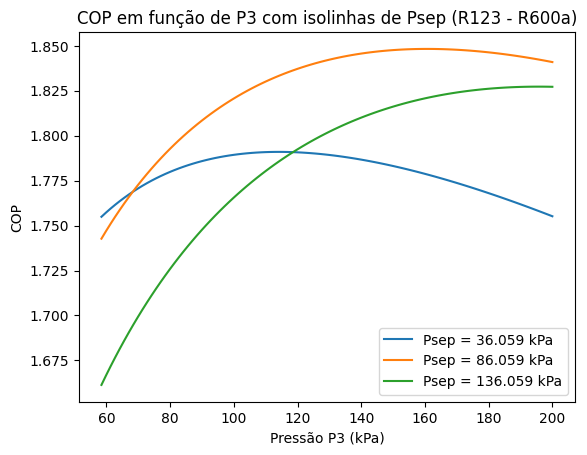

In [ ]:
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP
import numpy as np

# Valores fixados
refri1 = 'R123'  # Ciclo superior
refri2 = 'R600a'  # Ciclo inferior
carga_termica = 2000  # Carga térmica em watts
delta_T = 5  # Diferença de temperatura no trocador
T_cond = 50 + 273.15  # Temperatura de condensação do ciclo 1 (50°C)
efi = 0.7
superaquecimento = 5

# Valores de Psep para as isolinhas em Pa
valores_de_Psep = [36059, 86059, 136059]

# Intervalo de valores de P6 para o gráfico em Pa
valores_de_P2 = np.linspace(58427, 200000, 100)

# Loop sobre os valores de Psep (para as isolinhas)
for P_sep in valores_de_Psep:
    valores_COP = []
    pressoes_p2 = []

    # Loop para diferentes valores de P6
    for P_3 in valores_de_P2:

        # Estado 0
        t0 = 30 + 273.15  # Temperatura ambiente (K)
        p0 = 101325  # Pressão ambiente (Pa)
        h0_2 = CP.PropsSI('H', 'T', t0, 'P', p0, refri2)
        s0_2 = CP.PropsSI('S', 'T', t0, 'P', p0, refri2)
        h0_1 = CP.PropsSI('H', 'T', t0, 'P', p0, refri1)
        s0_1 = CP.PropsSI('S', 'T', t0, 'P', p0, refri1)
        tl = -16 + 273.15

        # Estado 1
        Temperatura_1 = -25 + 273.15
        h_1 = CP.PropsSI('H', 'T', Temperatura_1, 'Q', 1, refri2)
        P_1 = CP.PropsSI('P', 'T', Temperatura_1, 'Q', 1, refri2)
        s_1 = CP.PropsSI('S', 'T', Temperatura_1, 'Q', 1, refri2)
        af1 = (h_1 - h0_2) - (t0 * (s_1 - s0_2))

        # Estado 2
        P_2 = P_1
        Temperatura_2 = Temperatura_1 + superaquecimento
        h_2 = CP.PropsSI('H', 'T', Temperatura_2, 'P', P_2, refri2)
        s_2 = CP.PropsSI('S', 'T', Temperatura_2, 'P', P_2, refri2)
        af2 = (h_2 - h0_2) - (t0 * (s_2 - s0_2))

        # Estado 3
        s_3s = s_2
        h_3s = CP.PropsSI('H', 'S', s_3s, 'P', P_3, refri2)
        h_3 = ((h_3s - h_2) / efi) + h_2
        Temperatura_3 = CP.PropsSI('T', 'H', h_3, 'P', P_3, refri2)
        s_3 = CP.PropsSI('S', 'H', h_3, 'P', P_3, refri2)
        af3 = (h_3 - h0_2) - (t0 * (s_3 - s0_2))

        # Estado 4
        h_4 = CP.PropsSI('H', 'P', P_3, 'Q', 0, refri2)
        Temperatura_4 = CP.PropsSI('T', 'P', P_3, 'Q', 0, refri2)
        s_4 = CP.PropsSI('S', 'P', P_3, 'Q', 0, refri2)
        af4 = (h_4 - h0_2) - (t0 * (s_4 - s0_2))

        # Estado 5
        h_5 = h_1 + h_4 - h_2
        P_5 = P_3
        s_5 = CP.PropsSI('S', 'H', h_5, 'P', P_5, refri2)
        af5 = (h_5 - h0_2) - (t0 * (s_5 - s0_2))

        # Estado 6
        h_6 = h_5
        s_6 = CP.PropsSI('S', 'H', h_6, 'P', P_1, refri2)
        af6 = (h_6 - h0_2) - (t0 * (s_6 - s0_2))

        # Estado 7
        Temperatura_7 = Temperatura_4 - delta_T
        h_7 = CP.PropsSI('H', 'T', Temperatura_7, 'Q', 1, refri1)
        s_7 = CP.PropsSI('S', 'T', Temperatura_7, 'Q', 1, refri1)
        P_7 = CP.PropsSI('P', 'T', Temperatura_7, 'Q', 1, refri1)
        af7 = (h_7 - h0_1) - (t0 * (s_7 - s0_1))

        # Estado 8
        P_8 = P_sep
        s_8s = s_7
        h_8s = CP.PropsSI('H', 'P', P_8, 'S', s_8s, refri1)
        h_8 = ((h_8s - h_7) / efi) + h_7
        s_8 = CP.PropsSI('S', 'H', h_8, 'P', P_8, refri1)
        af8 = (h_8 - h0_1) - (t0 * (s_8 - s0_1))

        # Estado 9
        P_9 = P_sep
        h_9 = CP.PropsSI('H', 'P', P_9, 'Q', 0, refri1)
        s_9 = CP.PropsSI('S', 'P', P_9, 'Q', 0, refri1)
        af9 = (h_9 - h0_1) - (t0 * (s_9 - s0_1))

        # Estado 10
        h_10 = h_9
        Temperatura_10 = CP.PropsSI('T', 'P', P_7, 'H', h_10, refri1)
        s_10 = CP.PropsSI('S', 'P', P_7, 'H', h_10, refri1)
        af10 = (h_10 - h0_1) - (t0 * (s_10 - s0_1))

        # Estado 11
        P_11 = P_sep
        h_11 = CP.PropsSI('H', 'P', P_11, 'Q', 1, refri1)
        s_11 = CP.PropsSI('S', 'P', P_11, 'Q', 1, refri1)
        af11 = (h_11 - h0_1) - (t0 * (s_11 - s0_1))

        # Estado 13
        P_13 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
        h_13 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)
        s_13 = CP.PropsSI('S', 'T', T_cond, 'Q', 0, refri1)
        af13 = (h_13 - h0_1) - (t0 * (s_13 - s0_1))

        # Estado 12
        s_12s = s_11
        P_12 = P_13
        h_12s = CP.PropsSI('H', 'P', P_12, 'S', s_12s, refri1)
        h_12 = ((h_12s - h_11) / efi) + h_11
        s_12 = CP.PropsSI('S', 'H', h_12, 'P', P_12, refri1)
        af12 = (h_12 - h0_1) - (t0 * (s_12 - s0_1))

        # Estado 14
        h_14 = h_13
        P_14 = P_sep
        s_14 = CP.PropsSI('S', 'H', h_14, 'P', P_14, refri1)
        af14 = (h_14 - h0_1) - (t0 * (s_14 - s0_1))

        # Cálculo das vazões mássicas
        m1 = carga_termica / (h_1 - h_6)
        m2 = m1 * ((h_3 - h_4) / (h_7 - h_10))
        m3 = m2 * ((h_8 - h_9) / (h_11 - h_14))

        # Trabalhos e COP
        w1 = m1 * (h_3 - h_2)
        w2 = m2 * (h_8 - h_7)
        w3 = m3 * (h_12 - h_11)
        COP = carga_termica / (w1 + w2 + w3)

        # Armazenar os resultados para plotagem
        valores_COP.append(COP)
        pressoes_p2.append(P_3 / 1e3)  # Convertendo P6 para kPa

    # Plotar o gráfico UA x P2 para cada valor de Psep
    plt.plot(pressoes_p2, valores_COP, label=f'Psep = {P_sep / 1e3} kPa')

# Configurações do gráfico
plt.xlabel('Pressão P3 (kPa)')
plt.ylabel('COP')
plt.title('COP em função de P3 com isolinhas de Psep (R123 - R600a)')
plt.legend()
plt.grid(False)
plt.show()

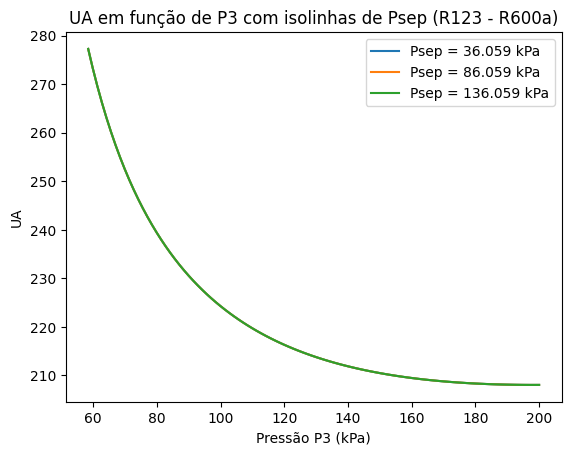

In [ ]:
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP
import numpy as np

# Valores fixados
refri1 = 'R123'  # Ciclo superior
refri2 = 'R600a'  # Ciclo inferior
carga_termica = 2000  # Carga térmica em watts
delta_T = 5  # Diferença de temperatura no trocador
T_cond = 50 + 273.15  # Temperatura de condensação do ciclo superior (50°C)
efi = 0.7
T_evap = -25 + 273.15
superaquecimento = 5

# Valores de Psep para as isolinhas em Pa
valores_de_Psep = [36059, 86059, 136059]

# Intervalo de valores de P6 para o gráfico em Pa
valores_de_P2 = np.linspace(58427, 200000, 100)

# Loop sobre os valores de Psep (para as isolinhas)
for P_sep in valores_de_Psep:
    valores_UA = []
    pressoes_p2 = []
    for P_3 in valores_de_P2:
        # Estado 0
        t0 = 30 + 273.15  # Temperatura ambiente (K)
        p0 = 101325  # Pressão ambiente (Pa)
        h0_2 = CP.PropsSI('H', 'T', t0, 'P', p0, refri2)
        s0_2 = CP.PropsSI('S', 'T', t0, 'P', p0, refri2)
        h0_1 = CP.PropsSI('H', 'T', t0, 'P', p0, refri1)
        s0_1 = CP.PropsSI('S', 'T', t0, 'P', p0, refri1)
        tl = -16 + 273.15

        # Estado 1
        Temperatura_1 = -25 + 273.15
        h_1 = CP.PropsSI('H', 'T', Temperatura_1, 'Q', 1, refri2)
        P_1 = CP.PropsSI('P', 'T', Temperatura_1, 'Q', 1, refri2)
        s_1 = CP.PropsSI('S', 'T', Temperatura_1, 'Q', 1, refri2)
        af1 = (h_1 - h0_2) - (t0 * (s_1 - s0_2))

        # Estado 2
        P_2 = P_1
        Temperatura_2 = Temperatura_1 + superaquecimento
        h_2 = CP.PropsSI('H', 'T', Temperatura_2, 'P', P_2, refri2)
        s_2 = CP.PropsSI('S', 'T', Temperatura_2, 'P', P_2, refri2)
        af2 = (h_2 - h0_2) - (t0 * (s_2 - s0_2))

        # Estado 3
        s_3s = s_2
        h_3s = CP.PropsSI('H', 'S', s_3s, 'P', P_3, refri2)
        h_3 = ((h_3s - h_2) / efi) + h_2
        Temperatura_3 = CP.PropsSI('T', 'H', h_3, 'P', P_3, refri2)
        s_3 = CP.PropsSI('S', 'H', h_3, 'P', P_3, refri2)
        af3 = (h_3 - h0_2) - (t0 * (s_3 - s0_2))

        # Estado 4
        h_4 = CP.PropsSI('H', 'P', P_3, 'Q', 0, refri2)
        Temperatura_4 = CP.PropsSI('T', 'P', P_3, 'Q', 0, refri2)
        s_4 = CP.PropsSI('S', 'P', P_3, 'Q', 0, refri2)
        af4 = (h_4 - h0_2) - (t0 * (s_4 - s0_2))

        # Estado 5
        h_5 = h_1 + h_4 - h_2
        P_5 = P_3
        s_5 = CP.PropsSI('S', 'H', h_5, 'P', P_5, refri2)
        af5 = (h_5 - h0_2) - (t0 * (s_5 - s0_2))

        # Estado 6
        h_6 = h_5
        s_6 = CP.PropsSI('S', 'H', h_6, 'P', P_1, refri2)
        af6 = (h_6 - h0_2) - (t0 * (s_6 - s0_2))

        # Estado 7
        Temperatura_7 = Temperatura_4 - delta_T
        h_7 = CP.PropsSI('H', 'T', Temperatura_7, 'Q', 1, refri1)
        s_7 = CP.PropsSI('S', 'T', Temperatura_7, 'Q', 1, refri1)
        P_7 = CP.PropsSI('P', 'T', Temperatura_7, 'Q', 1, refri1)
        af7 = (h_7 - h0_1) - (t0 * (s_7 - s0_1))

        # Estado 8
        P_8 = P_sep
        s_8s = s_7
        h_8s = CP.PropsSI('H', 'P', P_8, 'S', s_8s, refri1)
        h_8 = ((h_8s - h_7) / efi) + h_7
        s_8 = CP.PropsSI('S', 'H', h_8, 'P', P_8, refri1)
        af8 = (h_8 - h0_1) - (t0 * (s_8 - s0_1))

        # Estado 9
        P_9 = P_sep
        h_9 = CP.PropsSI('H', 'P', P_9, 'Q', 0, refri1)
        s_9 = CP.PropsSI('S', 'P', P_9, 'Q', 0, refri1)
        af9 = (h_9 - h0_1) - (t0 * (s_9 - s0_1))

        # Estado 10
        h_10 = h_9
        Temperatura_10 = CP.PropsSI('T', 'P', P_7, 'H', h_10, refri1)
        s_10 = CP.PropsSI('S', 'P', P_7, 'H', h_10, refri1)
        af10 = (h_10 - h0_1) - (t0 * (s_10 - s0_1))
        x10 = CP.PropsSI('Q', 'P', P_7, 'H', h_10, refri1)

        # Estado 11
        P_11 = P_sep
        h_11 = CP.PropsSI('H', 'P', P_11, 'Q', 1, refri1)
        s_11 = CP.PropsSI('S', 'P', P_11, 'Q', 1, refri1)
        af11 = (h_11 - h0_1) - (t0 * (s_11 - s0_1))

        # Estado 13
        P_13 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
        h_13 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)
        s_13 = CP.PropsSI('S', 'T', T_cond, 'Q', 0, refri1)
        af13 = (h_13 - h0_1) - (t0 * (s_13 - s0_1))

        # Estado 12
        s_12s = s_11
        P_12 = P_13
        h_12s = CP.PropsSI('H', 'P', P_12, 'S', s_12s, refri1)
        h_12 = ((h_12s - h_11) / efi) + h_11
        s_12 = CP.PropsSI('S', 'H', h_12, 'P', P_12, refri1)
        af12 = (h_12 - h0_1) - (t0 * (s_12 - s0_1))

        # Estado 14
        h_14 = h_13
        P_14 = P_sep
        s_14 = CP.PropsSI('S', 'H', h_14, 'P', P_14, refri1)
        af14 = (h_14 - h0_1) - (t0 * (s_14 - s0_1))

        # Cálculo das vazões mássicas
        m1 = carga_termica / (h_1 - h_6)
        m2 = m1 * ((h_3 - h_4) / (h_7 - h_10))
        m3 = m2 * ((h_8 - h_9) / (h_11 - h_14))

        # Trabalhos e COP
        w1 = m1 * (h_3 - h_2)
        w2 = m2 * (h_8 - h_7)
        w3 = m3 * (h_12 - h_11)
        COP = carga_termica / (w1 + w2 + w3)

        # Cálculo do UA
        delta_T_m = (((Temperatura_3 - Temperatura_10) - (Temperatura_4 - Temperatura_7)) / np.log((Temperatura_3 - Temperatura_10) / (Temperatura_4 - Temperatura_7)))
        Q = m2 * (h_7 - h_10)
        UA = Q / delta_T_m

        # Armazenar os resultados para plotagem
        valores_UA.append(UA)
        pressoes_p2.append(P_3 / 1e3)

    plt.plot(pressoes_p2, valores_UA, label=f'Psep = {P_sep / 1e3} kPa')

# Configurações do gráfico
plt.xlabel('Pressão P3 (kPa)')
plt.ylabel('UA')
plt.title('UA em função de P3 com isolinhas de Psep (R123 - R600a)')
plt.legend()
plt.grid(False)
plt.show()